In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

In [2]:
pd.options.mode.chained_assignment = None


In [3]:
# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

--------------------------------------------------------------
# Load data
--------------------------------------------------------------

In [4]:
df = pd.read_pickle('../../data/interim/01_dataprocessed.pkl')

In [5]:
df = df[df['label'] != 'rest']
df

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,bench,heavy,B,30
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,bench,heavy,B,30
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,bench,heavy,B,30
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,bench,heavy,B,30
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,bench,heavy,B,30
...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,row,medium,E,90
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,row,medium,E,90
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,row,medium,E,90


In [6]:
acc_r = df['acc_x'] ** 2 + df['acc_y'] ** 2 + df['acc_z'] ** 2
gyr_r = df['gyr_x'] ** 2 + df['gyr_y'] ** 2 + df['gyr_z'] ** 2

df['acc_r'] = np.sqrt(acc_r)
df['gyr_r'] = np.sqrt(gyr_r)

print(acc_r)
print(gyr_r)

epoch (ms)
2019-01-11 15:08:05.200    0.959752
2019-01-11 15:08:05.400    0.948193
2019-01-11 15:08:05.600    0.948277
2019-01-11 15:08:05.800    0.921827
2019-01-11 15:08:06.000    0.931134
                             ...   
2019-01-20 17:33:27.000    1.092879
2019-01-20 17:33:27.200    1.065800
2019-01-20 17:33:27.400    1.073285
2019-01-20 17:33:27.600    1.055482
2019-01-20 17:33:27.800    1.074573
Length: 7899, dtype: float64
epoch (ms)
2019-01-11 15:08:05.200    10.404654
2019-01-11 15:08:05.400     8.336328
2019-01-11 15:08:05.600     8.624326
2019-01-11 15:08:05.800    89.747245
2019-01-11 15:08:06.000    21.377539
                             ...    
2019-01-20 17:33:27.000    33.691343
2019-01-20 17:33:27.200    13.042268
2019-01-20 17:33:27.400    34.449584
2019-01-20 17:33:27.600     1.378254
2019-01-20 17:33:27.800    18.350756
Length: 7899, dtype: float64


--------------------------------------------------------------
# Split data
--------------------------------------------------------------

In [7]:
bench_df = df[df['label'] == 'bench']
squat_df = df[df['label'] == 'squat']
ohp_df = df[df['label'] == 'ohp']
row_df = df[df['label'] == 'row']
dead_df = df[df['label'] == 'dead']

--------------------------------------------------------------
# Visualize data to identify patterns
--------------------------------------------------------------

<AxesSubplot: xlabel='epoch (ms)'>

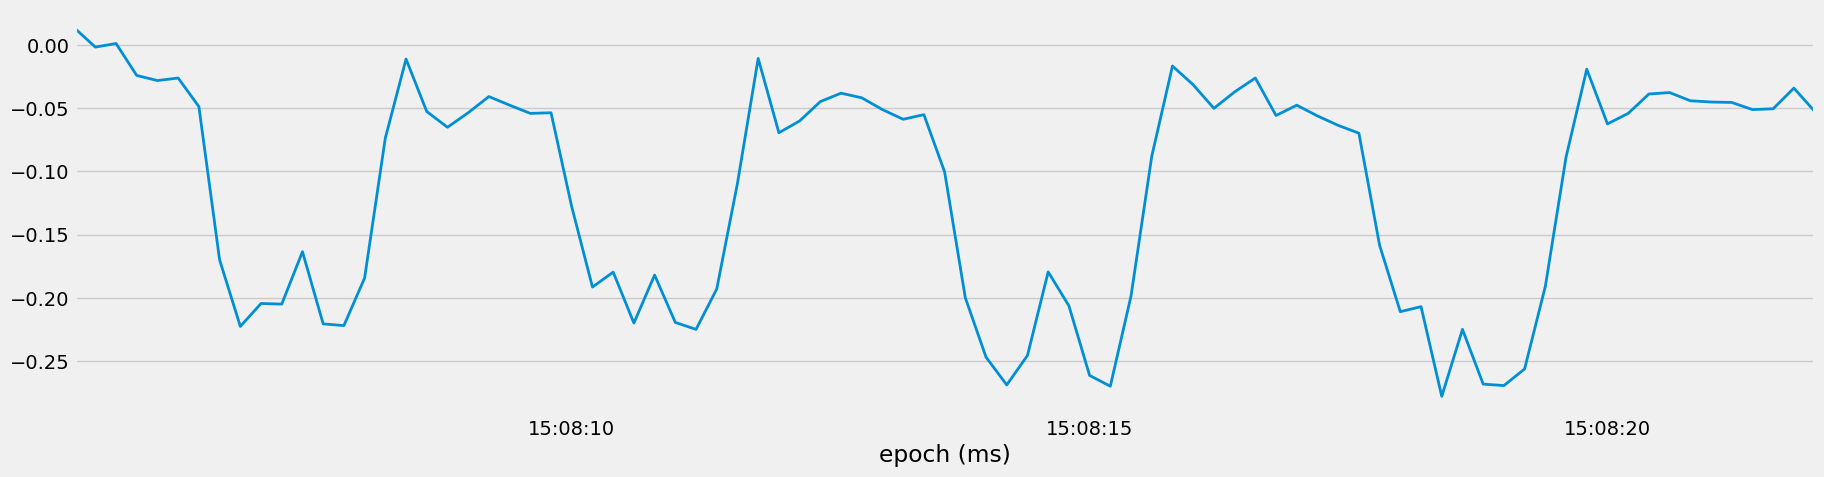

In [8]:
plot_df = bench_df

plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_x'].plot()


<AxesSubplot: xlabel='epoch (ms)'>

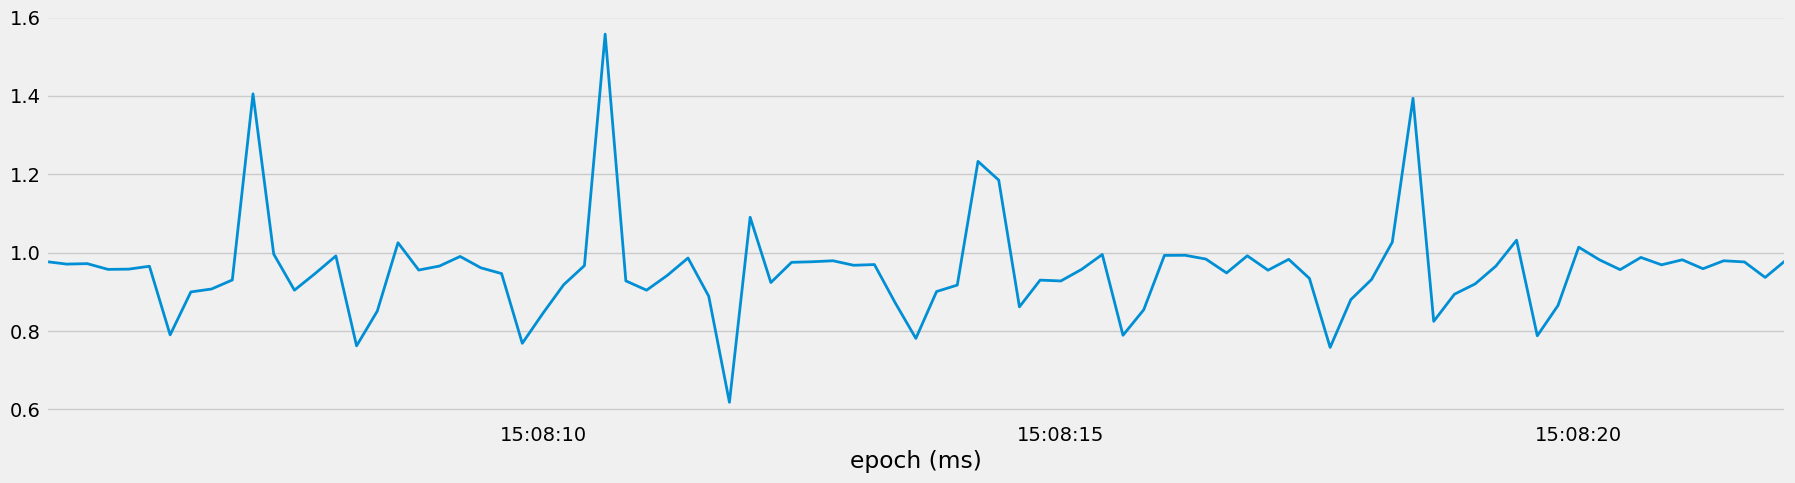

In [9]:
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_y'].plot()

<AxesSubplot: xlabel='epoch (ms)'>

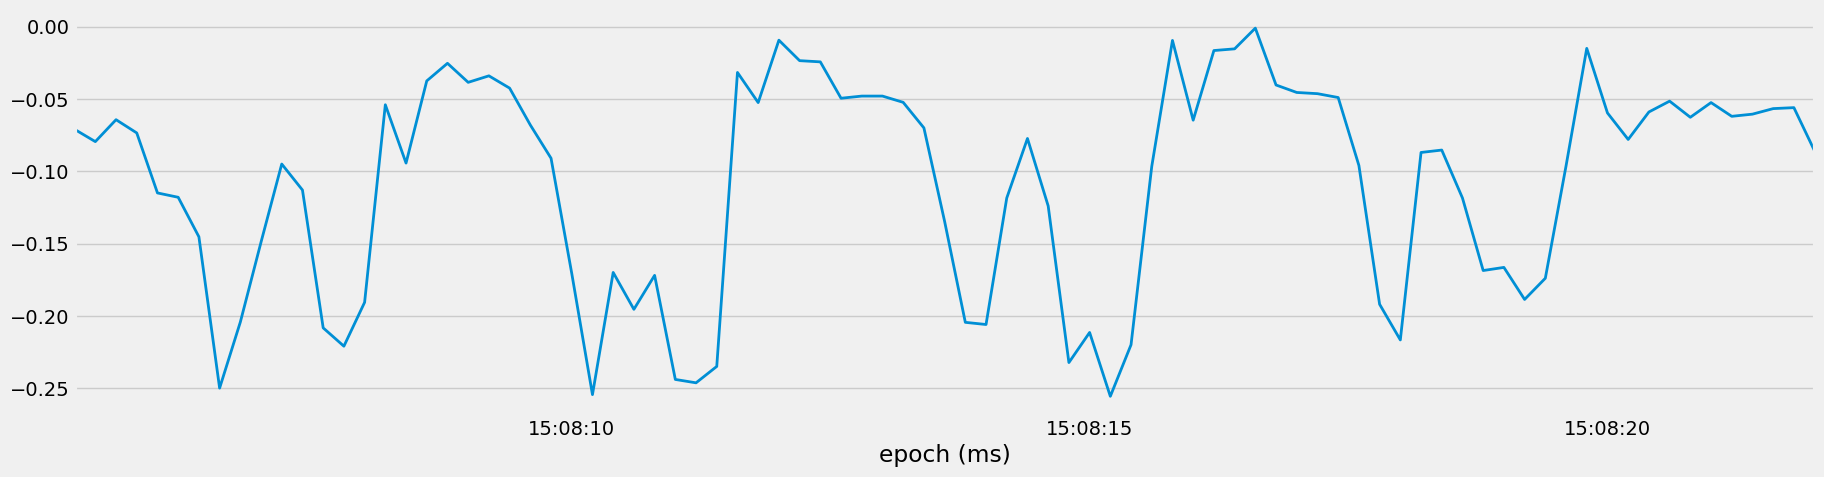

In [10]:
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_z'].plot()

<AxesSubplot: xlabel='epoch (ms)'>

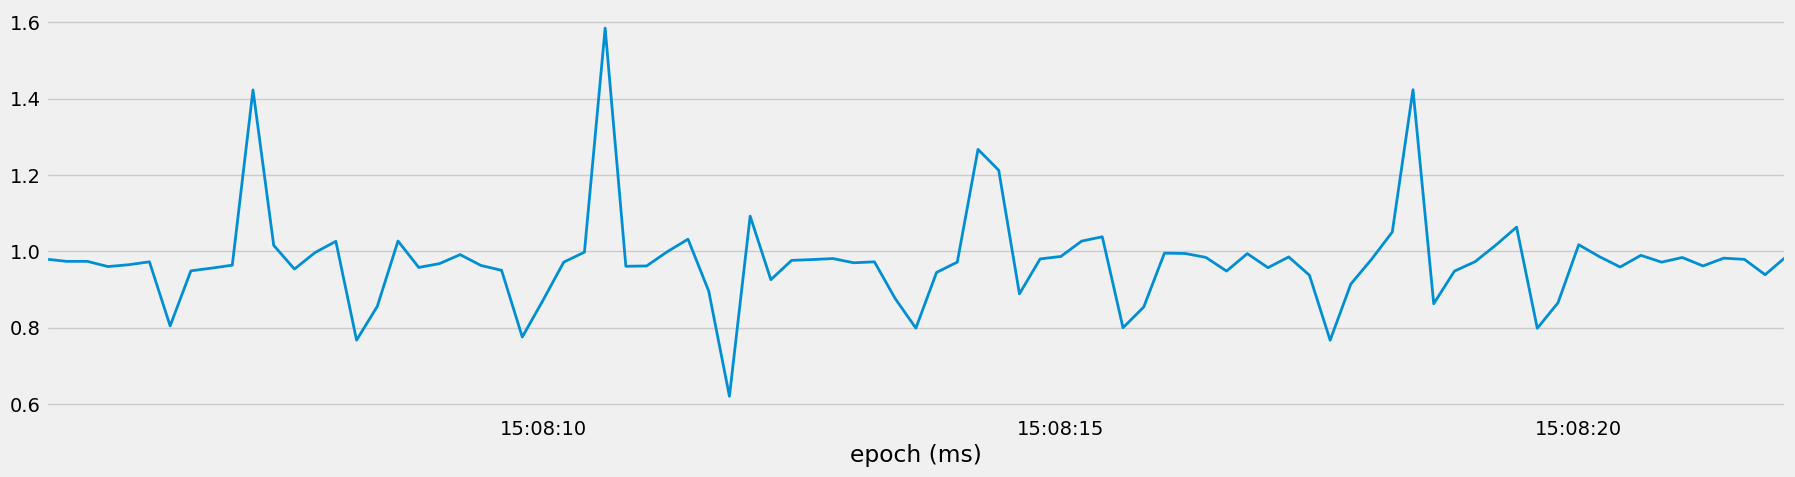

In [11]:
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_r'].plot()

<AxesSubplot: xlabel='epoch (ms)'>

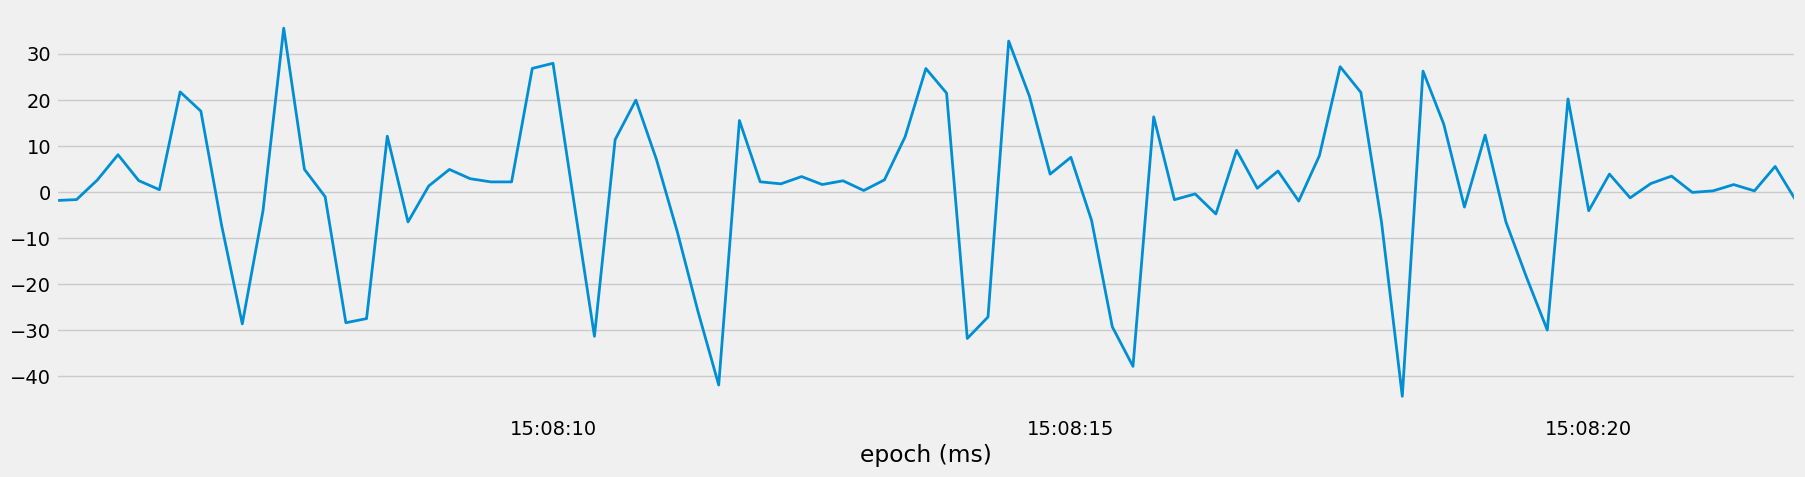

In [12]:
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['gyr_x'].plot()

<AxesSubplot: xlabel='epoch (ms)'>

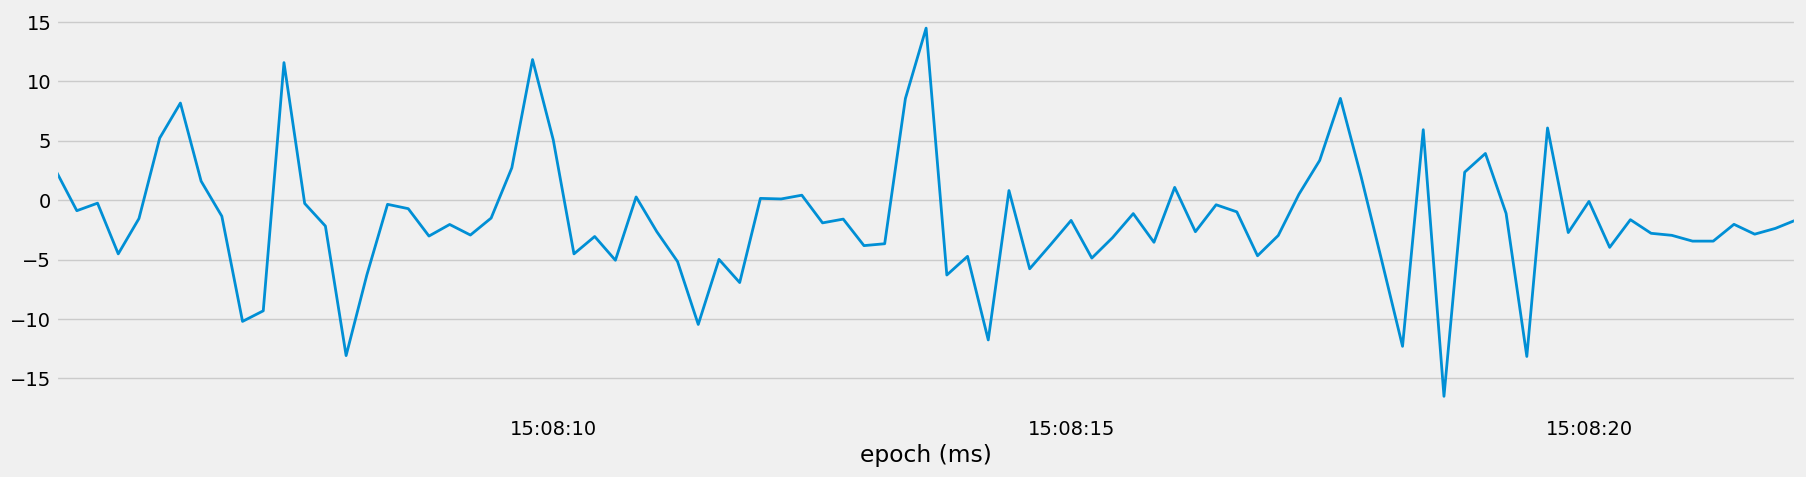

In [13]:
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['gyr_y'].plot()

--------------------------------------------------------------
# Configure LowPassFilter
--------------------------------------------------------------

In [14]:
fs = 1000/200

LowPass = LowPassFilter()

--------------------------------------------------------------
# Apply and tweak LowPassFilter
--------------------------------------------------------------

In [15]:
bench_set = bench_df[bench_df['set'] == bench_df['set'].unique()[0]]
squat_set = squat_df[squat_df['set'] == squat_df['set'].unique()[0]]
row_set = row_df[row_df['set'] == row_df['set'].unique()[0]]
ohp_set = ohp_df[ohp_df['set'] == ohp_df['set'].unique()[0]]
dead_set = dead_df[dead_df['set'] == dead_df['set'].unique()[0]]

In [16]:
bench_df

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.890400,2.439200,0.9388,bench,heavy,B,30,0.979669,3.225625
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.682600,-0.890400,2.1708,bench,heavy,B,30,0.973752,2.887270
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.560800,-0.256000,-1.4146,bench,heavy,B,30,0.973795,2.936720
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.061000,-4.524400,-2.0730,bench,heavy,B,30,0.960118,9.473502
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.439000,-1.548600,-3.6098,bench,heavy,B,30,0.964953,4.623585
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-19 17:24:41.800,0.013000,1.026667,-0.096333,-1.268400,2.841600,2.0610,bench,medium,E,71,1.031258,3.732459
2019-01-19 17:24:42.000,0.017500,0.955000,-0.075000,0.451200,0.024400,0.5242,bench,medium,E,71,0.958100,0.692071
2019-01-19 17:24:42.200,0.023667,0.964000,-0.086333,1.475600,-0.024200,1.5974,bench,medium,E,71,0.968147,2.174780


<AxesSubplot: xlabel='epoch (ms)'>

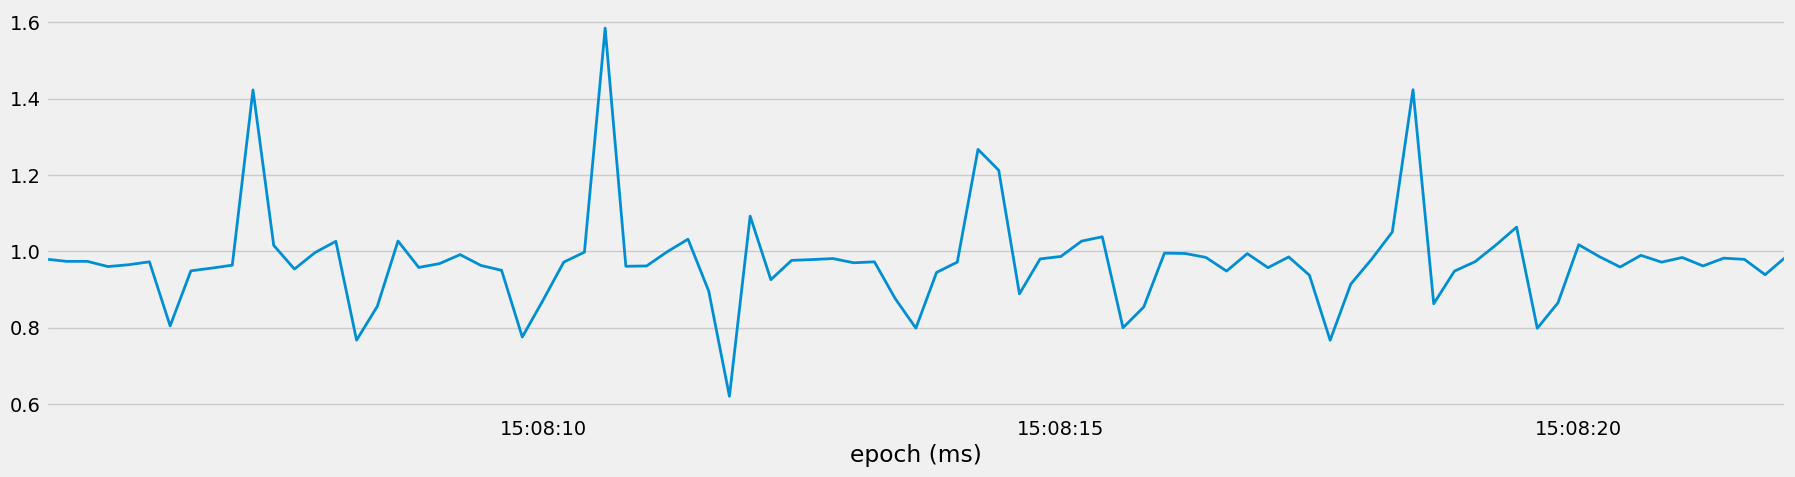

In [18]:
bench_set['acc_r'].plot()

<AxesSubplot: xlabel='epoch (ms)'>

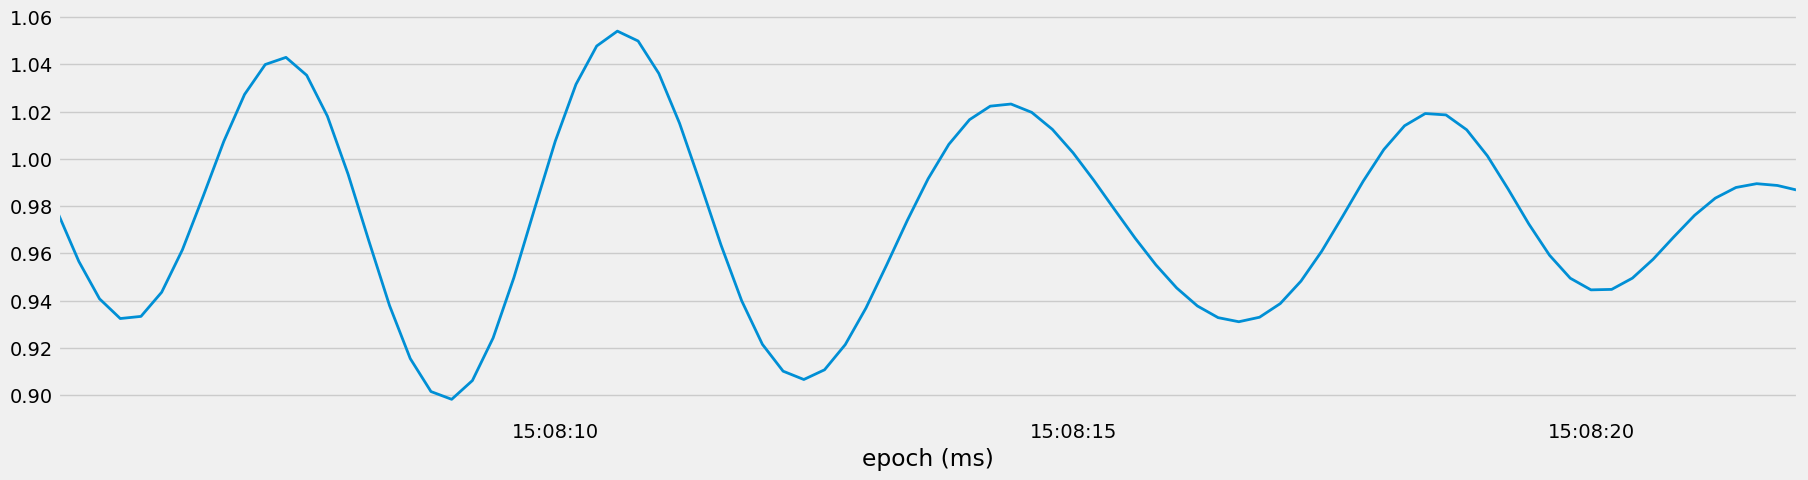

In [19]:
col = 'acc_r'

LowPass.low_pass_filter(bench_set, col=col, sampling_frequency=fs, cutoff_frequency=0.4, order=10)[col+'_lowpass'].plot()

--------------------------------------------------------------
# Create function to count repetitions
--------------------------------------------------------------

In [20]:
def count_reps(dataset, cutoff=0.4, order = 10, col = 'acc_r', plot_graph = False):
    data = LowPass.low_pass_filter(dataset, col=col, sampling_frequency=fs, cutoff_frequency=cutoff, order=order)
    indexes = argrelextrema(data[col+'_lowpass'].values, np.greater)
    peaks = data.iloc[indexes]
    
    if plot_graph:
        fig, ax = plt.subplots()
        plt.plot(dataset[f'{col}_lowpass'])
        plt.plot(peaks[f'{col}_lowpass'], 'o', color = 'red')
        ax.set_ylabel(f'{col}_lowpass')
        exercise = dataset['label'].iloc[0].title()
        category = dataset['category'].iloc[0].title()
        plt.title(f'{category} {exercise} : {len(peaks)} Reps')
        plt.show()
    
    return len(peaks)

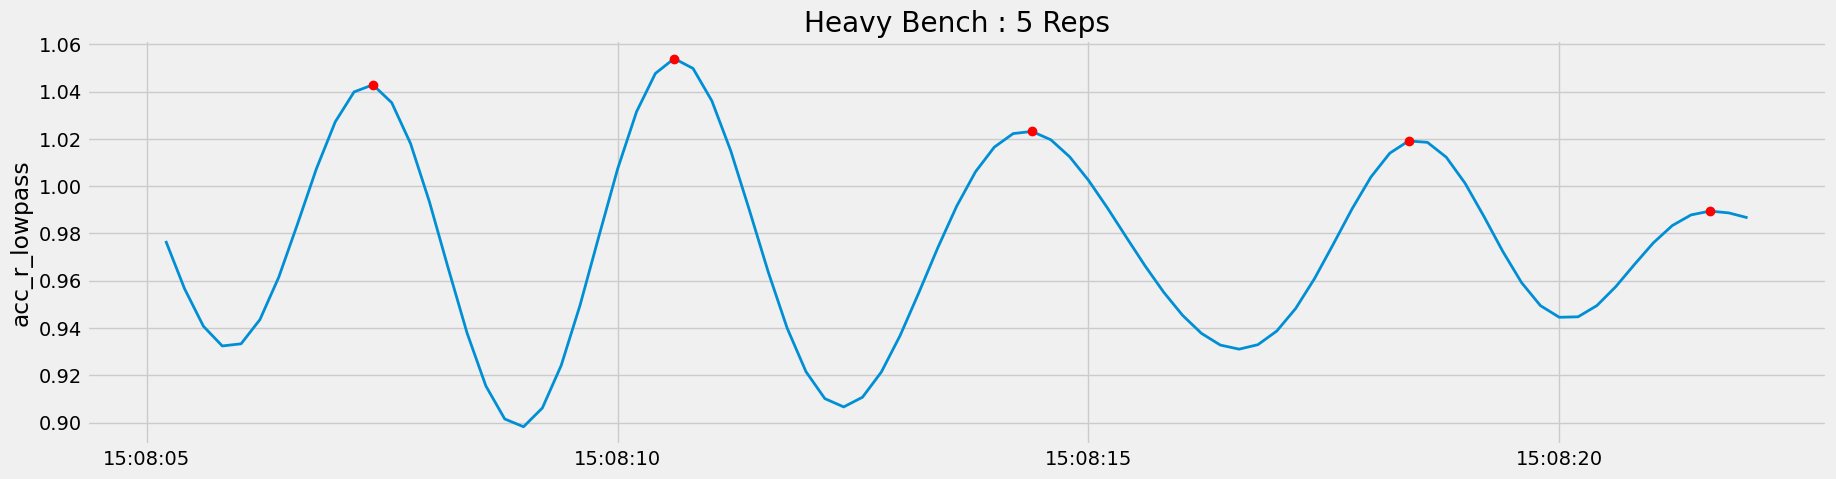

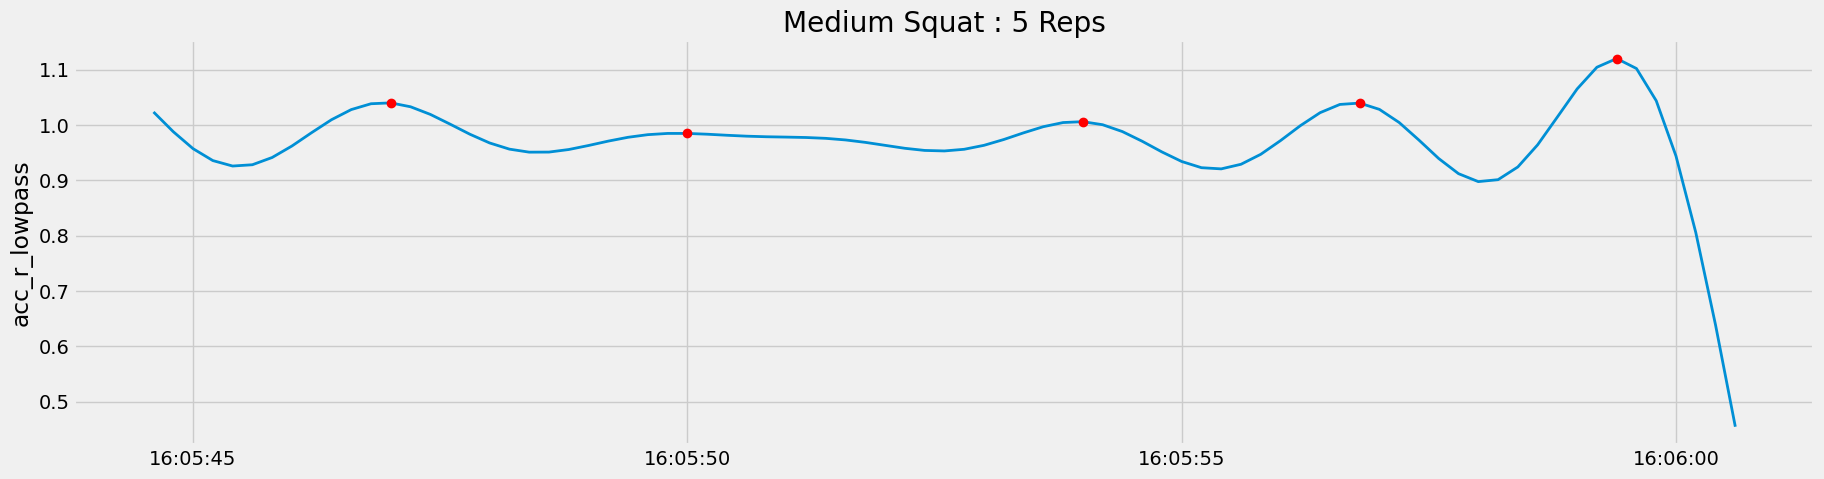

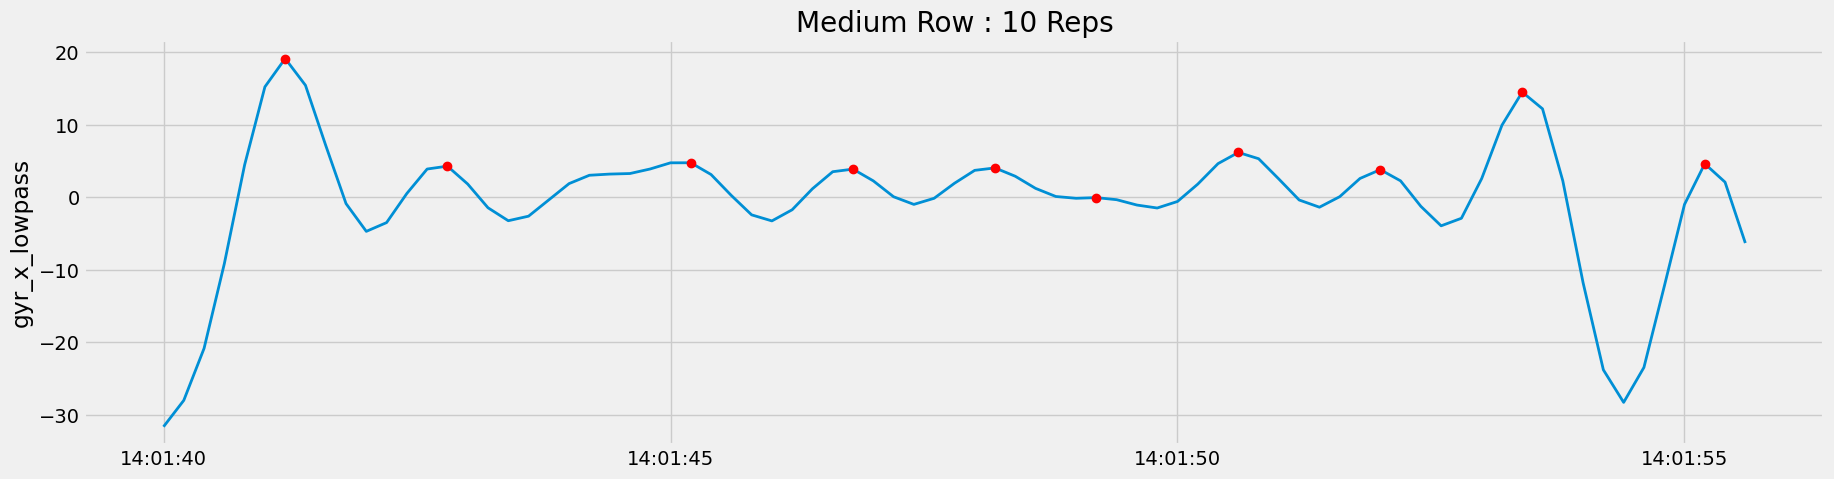

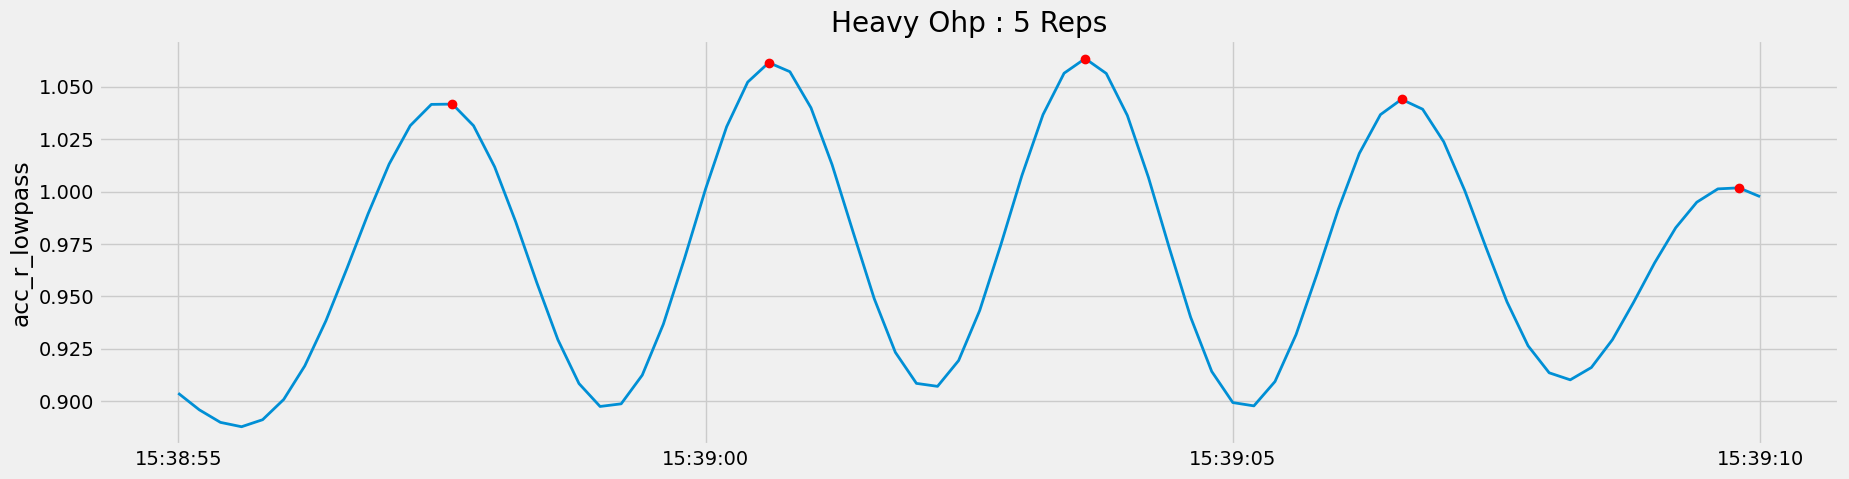

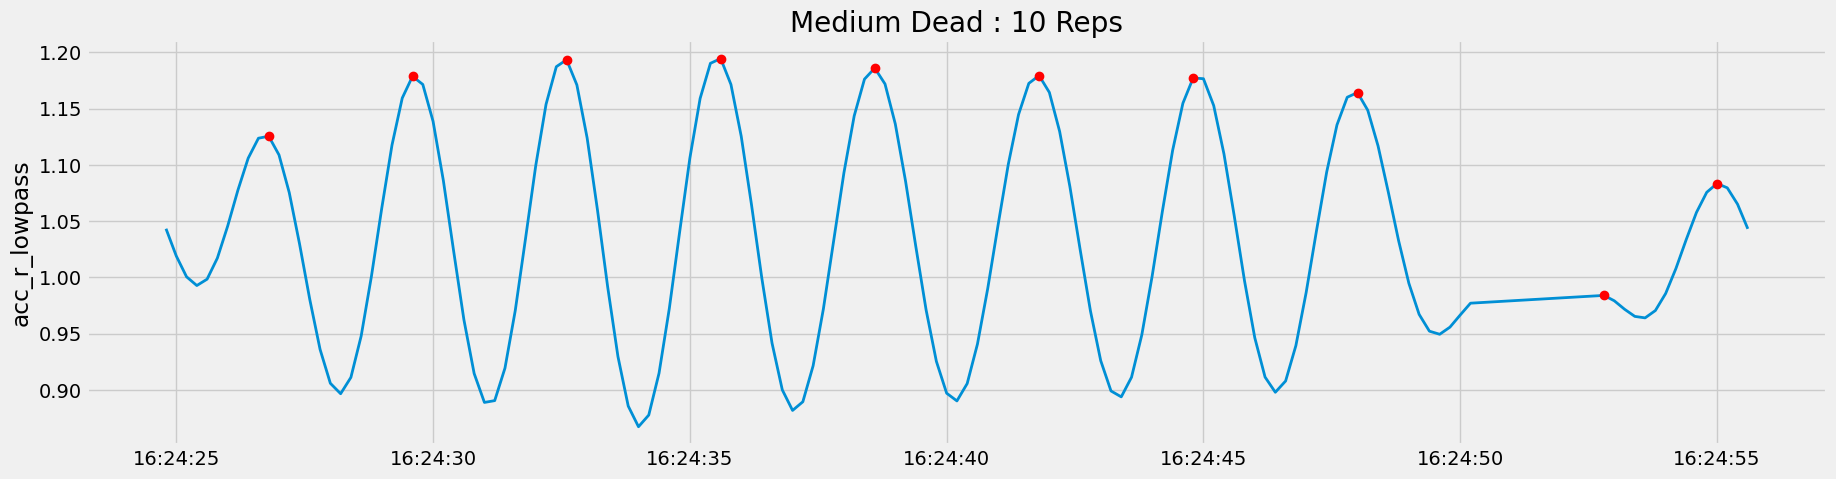

10

In [24]:
count_reps(bench_set,cutoff=0.4, plot_graph=True)
count_reps(squat_set,cutoff=0.35, plot_graph=True)
count_reps(row_set,cutoff=0.65, col='gyr_x', plot_graph=True)
count_reps(ohp_set,cutoff=0.35, plot_graph=True)
count_reps(dead_set,cutoff=0.4, plot_graph=True)

--------------------------------------------------------------
# Create benchmark dataframe
--------------------------------------------------------------

In [29]:
df['reps'] = df['category'].apply(lambda x: 5 if x == 'heavy' else 10)
rep_df = df.groupby(['label', 'category', 'set'])['reps'].max().reset_index()
rep_df['reps_pred'] = 0
rep_df

,label,category,set,reps,reps_pred
0,bench,heavy,1,5,0
1,bench,heavy,2,5,0
2,bench,heavy,3,5,0
3,bench,heavy,4,5,0
4,bench,heavy,30,5,0
...,...,...,...,...,...
80,squat,medium,28,10,0
81,squat,medium,29,10,0
82,squat,medium,38,10,0
83,squat,medium,63,10,0


In [30]:
for s in df['set'].unique():
    subset = df[df['set'] == s]
    
    col == 'acc_r'
    cutoff = 0.4
    
    if subset['label'].iloc[0] == 'squat':
        cutoff = 0.35
    
    if subset['label'].iloc[0] == 'row':
        cutoff = 0.65
        col = 'gyr_x'
    
    if subset['label'].iloc[0] == 'ohp':
        cutoff = 0.35
        
    reps = count_reps(subset, cutoff=cutoff, col=col)
    
    rep_df.loc[rep_df['set'] == s, 'reps_pred'] = reps

In [31]:
rep_df

,label,category,set,reps,reps_pred
0,bench,heavy,1,5,5
1,bench,heavy,2,5,4
2,bench,heavy,3,5,5
3,bench,heavy,4,5,5
4,bench,heavy,30,5,5
...,...,...,...,...,...
80,squat,medium,28,10,8
81,squat,medium,29,10,8
82,squat,medium,38,10,7
83,squat,medium,63,10,11


In [33]:
error = mean_absolute_error(rep_df['reps'], rep_df['reps_pred']).round(2)
error

0.87

/tmp/ipykernel_1396/214815350.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rep_df.groupby(['label', 'category'])['reps','reps_pred'].mean().plot.bar()


<AxesSubplot: xlabel='label,category'>

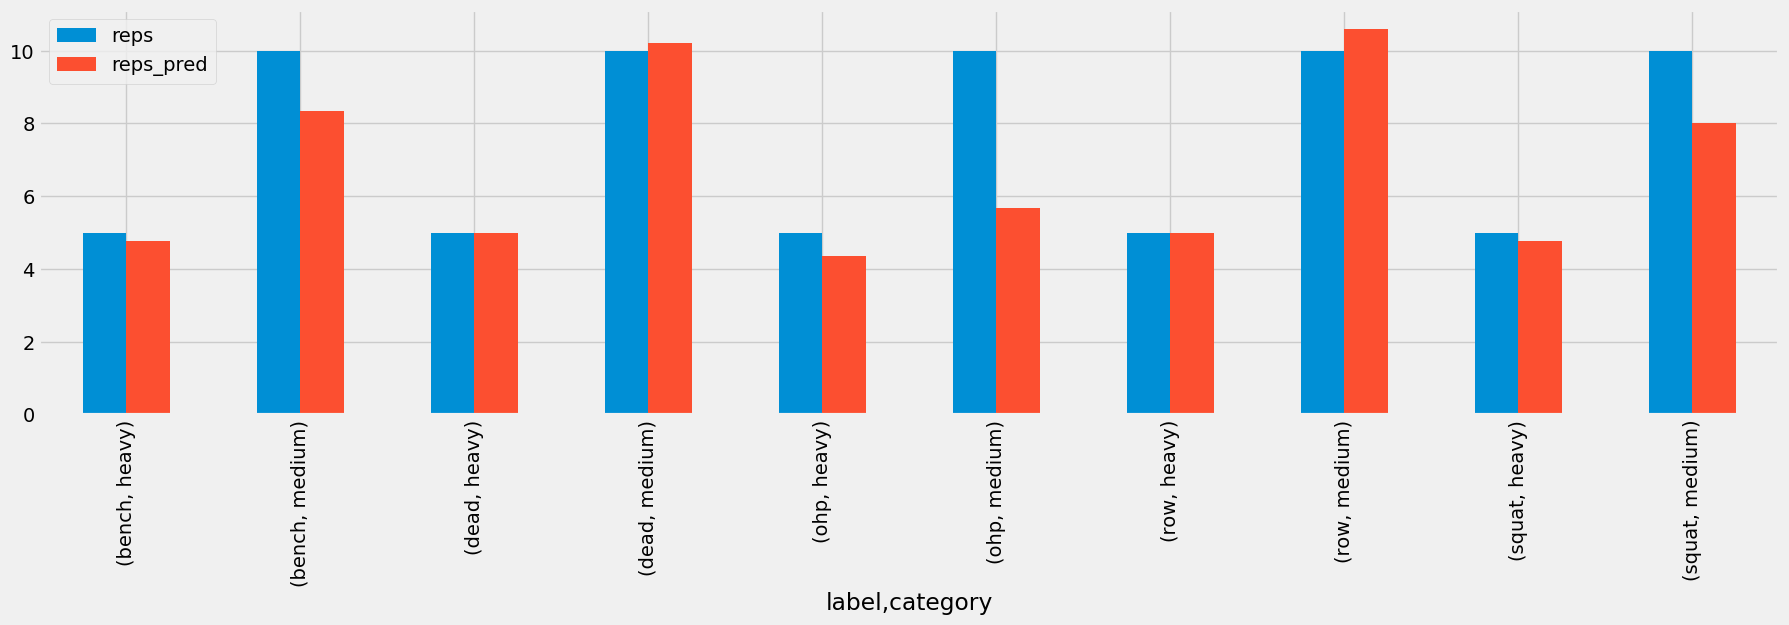

In [34]:
rep_df.groupby(['label', 'category'])['reps','reps_pred'].mean().plot.bar()